# R2X: Plexos & Sienna Comparison

In [215]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
def add_missing_carriers(df1, df2):
    for carrier in df1.columns:
        if carrier not in df2.columns:
            df2[carrier] = 0
    for carrier in df2.columns:
        if carrier not in df1.columns:
            df1[carrier] = 0
    return df1, df2

In [217]:
colors_fuel = {
    "Natural gas": "#800080",
    "Hydropower": "#1f77b4",
    "Wind": "#87ceeb", 
    "Biopower": "#228b22",
    "Geothermal": "#8b4513",   
    "PV": "#ffd700",          
    "Storage": "#5dbb26",  
    "Storage_Charge": "#5dbb26",
    "Storage_Discharge": "#5dbb26",
    "Petroleum": "#333333", 
    "Other": "#bcbd22",     
    "Unserved Energy": "#ff0000", 
    "Curtailment": "#ff6347", 
    "Over Generation": "#00ff00",
}

fuel_name_mapper = { # Maps fuel names/ PM names to the fuel names used in Sienna data
    'OIL': 'Petroleum',
    'OTHER': 'Other',
    'HY': 'Hydropower',
    'WT': 'Wind',
    'WOOD_WASTE': 'Biopower',
    'WASTE_HEAT': 'Other',
    'GEOTHERMAL': 'Geothermal',
    'GAS': 'Natural gas',
    'PV': 'PV',
    'BA': 'Storage',
    'HYDROGEN': 'Other',
}

sienna_results_folder = Path('run_output/results')
plexos_results_path = Path('PLEXOS ST Results NVE 7_19_24  No AS 2030-2.xlsx')

## Demand Comparison

In [218]:
# Read Sienna Demand
df_sienna_demand = (pd.read_csv(sienna_results_folder / 'load_active_power.csv') *-1)
df_sienna_demand

,DateTime,Nevada Power,Sierra
0,,2505.00,1832.89
1,,2379.29,1773.25
2,,2319.46,1734.14
3,,2288.37,1724.12
4,,2295.62,1731.20
...,...,...,...
115,,2552.91,1810.91
116,,2465.24,1766.19
117,,2388.65,1738.71
118,,2377.58,1732.47


In [219]:
# Read Plexos Results
df_plexos_load = pd.read_excel(plexos_results_path, sheet_name='Native Load')
df_plexos_load.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_load.rename(columns={"Datetime": "DateTime"}, inplace=True)
# Remove any zero load columns
df_plexos_load = df_plexos_load.iloc[:len(df_sienna_demand)]
df_plexos_load.set_index('DateTime', inplace=True)
df_plexos_load = df_plexos_load.loc[:, (df_plexos_load.sum(axis=0) != 0)]
df_plexos_load.head(5)


,Nevada Power,Sierra
DateTime,,
2030-01-01 00:00:00,2505.00,1832.89
2030-01-01 01:00:00,2379.29,1773.25
2030-01-01 02:00:00,2319.46,1734.14
2030-01-01 03:00:00,2288.37,1724.12
2030-01-01 04:00:00,2295.62,1731.20


<Axes: >

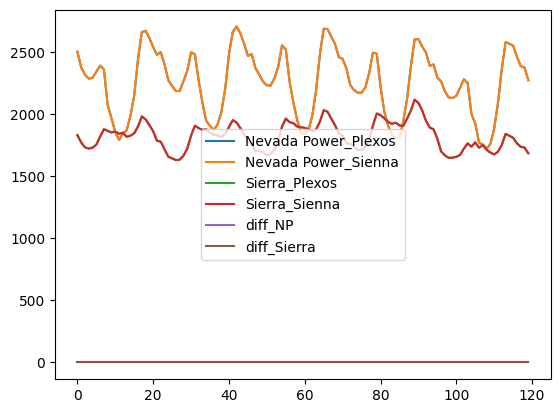

In [220]:
df_plexos_load = df_plexos_load[['Nevada Power', 'Sierra']].add_suffix('_Plexos')
df_sienna_demand = df_sienna_demand[['Nevada Power', 'Sierra']].add_suffix('_Sienna')

df = pd.DataFrame(
    [
        df_plexos_load['Nevada Power_Plexos'].reset_index(drop=True), 
        df_sienna_demand['Nevada Power_Sienna'].reset_index(drop=True),
        df_plexos_load['Sierra_Plexos'].reset_index(drop=True),
        df_sienna_demand['Sierra_Sienna'].reset_index(drop=True),
        ]
).T

df['diff_NP'] = df['Nevada Power_Plexos'] - df['Nevada Power_Sienna']
df['diff_Sierra'] = df['Sierra_Plexos'] - df['Sierra_Sienna']
df
df.plot()

## Generation Comparison

In [221]:
# Load Generator Fuel Mapping File
gen_properties = pd.read_csv(Path('../output/gen.csv'), index_col=0)
gen_properties['fuel_type'] = gen_properties.fuel.fillna(gen_properties.prime_mover_type)
gen_properties['fuel_name'] = gen_properties.fuel_type.map(fuel_name_mapper)
print(gen_properties.fuel_name.unique())
print(gen_properties.fuel_type.unique())

['Wind' 'PV' 'Hydropower' 'Storage' 'Other' 'Petroleum' 'Natural gas'
 'Biopower' 'Geothermal']
['WT' 'PV' 'HY' 'BA' 'OTHER' 'OIL' 'GAS' 'WOOD_WASTE' 'GEOTHERMAL']


In [222]:
# Read Plexos Results
df_plexos_generation = pd.read_excel(plexos_results_path, sheet_name='Generation')
df_plexos_generation.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_generation.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_generation.set_index('DateTime', inplace=True)
# Add storage data
df_plexos_storage = pd.read_excel(plexos_results_path, sheet_name='Net_Gen (stor)')
df_plexos_storage.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_storage.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_storage.set_index('DateTime', inplace=True)

df_plexos_generation = pd.concat([df_plexos_generation, df_plexos_storage], axis=1)
df_plexos_generation.head(5)

,Chuck Lenzi 1_A,Chuck Lenzi 1_B,Chuck Lenzi 2_A,Chuck Lenzi 2_B,"Clark 5, 6, 10_A","Clark 5, 6, 10_B","Clark 7, 8, 9_A","Clark 7, 8, 9_B",Harry Allen CC_A,Harry Allen CC_B,...,Arrow Canyon Solar BESS,Battle Mountain Solar BESS,Boulder Solar III BESS,Dodge Flat Solar BESS,Dry Lake East Solar BESS,Dry Lake Solar BESS,Fish Springs Ranch Solar BESS,Gemini Solar BESS,Libra Solar BESS,Sierra Solar BESS
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 01:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 02:00:00,268.389,268.389,268.389,268.389,0,0,0,0,290.0,290.0,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.0
2030-01-01 03:00:00,268.389,268.389,268.389,289.944,0,0,0,0,290.0,290.0,...,39.097,0.0,0.000,10.852,0.0,21.704,0.000,0.00,321.845,0.0
2030-01-01 04:00:00,268.389,268.389,268.389,289.944,0,0,0,0,290.0,290.0,...,0.000,0.0,27.759,0.000,0.0,0.000,5.406,47.79,530.083,0.0


/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_93597/4189597764.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()


<Axes: xlabel='DateTime'>

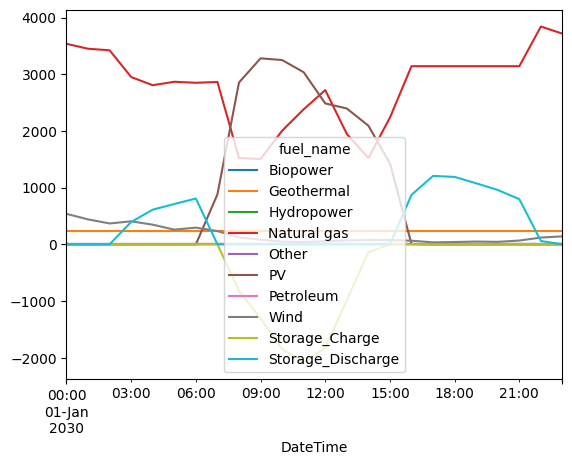

In [223]:
# Group plexos results by fuel type
df_plexos_gen_by_fuel = df_plexos_generation.groupby(gen_properties.fuel_name, axis =1).sum()

df_plexos_gen_by_fuel['Storage_Charge'] = df_plexos_gen_by_fuel['Storage'].clip(upper=0)
df_plexos_gen_by_fuel['Storage_Discharge'] = df_plexos_gen_by_fuel['Storage'].clip(lower=0)
df_plexos_gen_by_fuel.drop(columns=['Storage'], inplace=True)

df_plexos_gen_by_fuel.head(24).plot()

In [256]:
# Read Sienna Resuts
df_sienna_gen = pd.read_csv(sienna_results_folder / 'generator_active_power.csv')
df_sienna_fuel = pd.read_csv(sienna_results_folder / 'generation_by_fuel.csv')
df_storage_charge = pd.read_csv(sienna_results_folder / 'storage_charge.csv', index_col=0)
df_sienna_gen['DateTime'] = pd.to_datetime(df_sienna_gen['DateTime'])
df_sienna_gen.set_index('DateTime', inplace=True)
df_sienna_fuel.Curtailment = df_sienna_fuel.Curtailment.clip(lower=0) # clip small negative curtailment values
df_sienna_fuel.index = df_sienna_gen.index # assign timestamp

df_sienna_fuel['Storage_Charge'] = (df_storage_charge.sum(axis=1) * -1).clip(upper=0).values
df_sienna_fuel.rename(columns={'Storage':'Storage_Discharge'}, inplace=True)
df_sienna_fuel.head(5)

,Curtailment,Petroleum,Other,Wind,Biopower,Storage_Discharge,Geothermal,PV,Natural gas,Hydropower,Storage_Charge
DateTime,,,,,,,,,,,
2030-01-01 00:00:00,7.951026e-08,0.0,7.5,538.927074,15.2,29.602946,282.25,527.87,2843.539986,93.0,-0.000005
2030-01-01 01:00:00,9.282093e-08,0.0,7.5,441.213188,15.2,0.000000,282.25,664.85,2806.354408,93.0,-157.827595
2030-01-01 02:00:00,9.206417e-08,0.0,7.5,369.354966,15.2,0.000000,282.25,637.76,2806.359773,93.0,-157.824739
2030-01-01 03:00:00,7.834598e-08,0.0,7.5,406.914254,15.2,220.046523,282.25,144.04,2843.539229,93.0,-0.000006
2030-01-01 04:00:00,7.991549e-08,0.0,7.5,347.742956,15.2,437.587873,282.25,0.00,2843.539175,93.0,-0.000004


In [271]:
# modify plot to show imports as thermal
df_sienna_fuel['Natural gas'] = df_sienna_fuel['Natural gas'] + df_sienna_gen[['Southern Purchases (NVP)','Northern Purchases (Sierra)']].sum(axis=1)
df_sienna_fuel['PV'] = df_sienna_fuel['PV'] - df_sienna_gen[['Southern Purchases (NVP)','Northern Purchases (Sierra)']].sum(axis=1)

In [273]:
# Prepare for plotting
plexos = df_plexos_gen_by_fuel.loc[df_sienna_fuel.index].copy()
sienna = df_sienna_fuel
 
COLUMN_ORDER = ['Geothermal', 'Biopower', 'Hydropower', 'Petroleum', 'Other','Natural gas', 'Wind', 'PV', 'Unserved Energy', 'Curtailment', 'Over Generation', 'Storage_Discharge', 'Storage_Charge']

plexos = plexos.reindex(columns=COLUMN_ORDER)
sienna = sienna.reindex(columns=COLUMN_ORDER)

plexos.head(5)

fuel_name,Geothermal,Biopower,Hydropower,Petroleum,Other,Natural gas,Wind,PV,Unserved Energy,Curtailment,Over Generation,Storage_Discharge,Storage_Charge
DateTime,,,,,,,,,,,,,
2030-01-01 00:00:00,228.346,15.2,7.634,0.0,6.0,3539.783,538.927,0.0,NaN,NaN,NaN,2.000,0.0
2030-01-01 01:00:00,228.346,15.2,7.634,0.0,6.0,3452.146,441.213,0.0,NaN,NaN,NaN,2.000,0.0
2030-01-01 02:00:00,228.346,15.2,7.634,0.0,6.0,3425.065,369.355,0.0,NaN,NaN,NaN,2.000,0.0
2030-01-01 03:00:00,228.346,15.2,7.634,0.0,6.0,2952.897,406.914,0.0,NaN,NaN,NaN,395.498,0.0
2030-01-01 04:00:00,228.346,15.2,7.634,0.0,6.0,2808.858,347.743,0.0,NaN,NaN,NaN,613.038,0.0


In [274]:
sienna.head(5)

,Geothermal,Biopower,Hydropower,Petroleum,Other,Natural gas,Wind,PV,Unserved Energy,Curtailment,Over Generation,Storage_Discharge,Storage_Charge
DateTime,,,,,,,,,,,,,
2030-01-01 00:00:00,282.25,15.2,93.0,0.0,7.5,3371.409986,538.927074,0.0,NaN,7.951026e-08,NaN,29.602946,-0.000005
2030-01-01 01:00:00,282.25,15.2,93.0,0.0,7.5,3471.204408,441.213188,0.0,NaN,9.282093e-08,NaN,0.000000,-157.827595
2030-01-01 02:00:00,282.25,15.2,93.0,0.0,7.5,3444.119773,369.354966,0.0,NaN,9.206417e-08,NaN,0.000000,-157.824739
2030-01-01 03:00:00,282.25,15.2,93.0,0.0,7.5,2987.579229,406.914254,0.0,NaN,7.834598e-08,NaN,220.046523,-0.000006
2030-01-01 04:00:00,282.25,15.2,93.0,0.0,7.5,2843.539175,347.742956,0.0,NaN,7.991549e-08,NaN,437.587873,-0.000004


In [275]:
# plexos, sienna = add_missing_carriers(plexos, sienna)

start_time = pd.Timestamp(2030, 1, 1)
end_time = pd.Timestamp(2030, 1, 6)

sienna = sienna.loc[start_time:end_time]
plexos = plexos.loc[start_time:end_time]

/Users/kamrantehranchi/miniforge3/envs/r2x/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


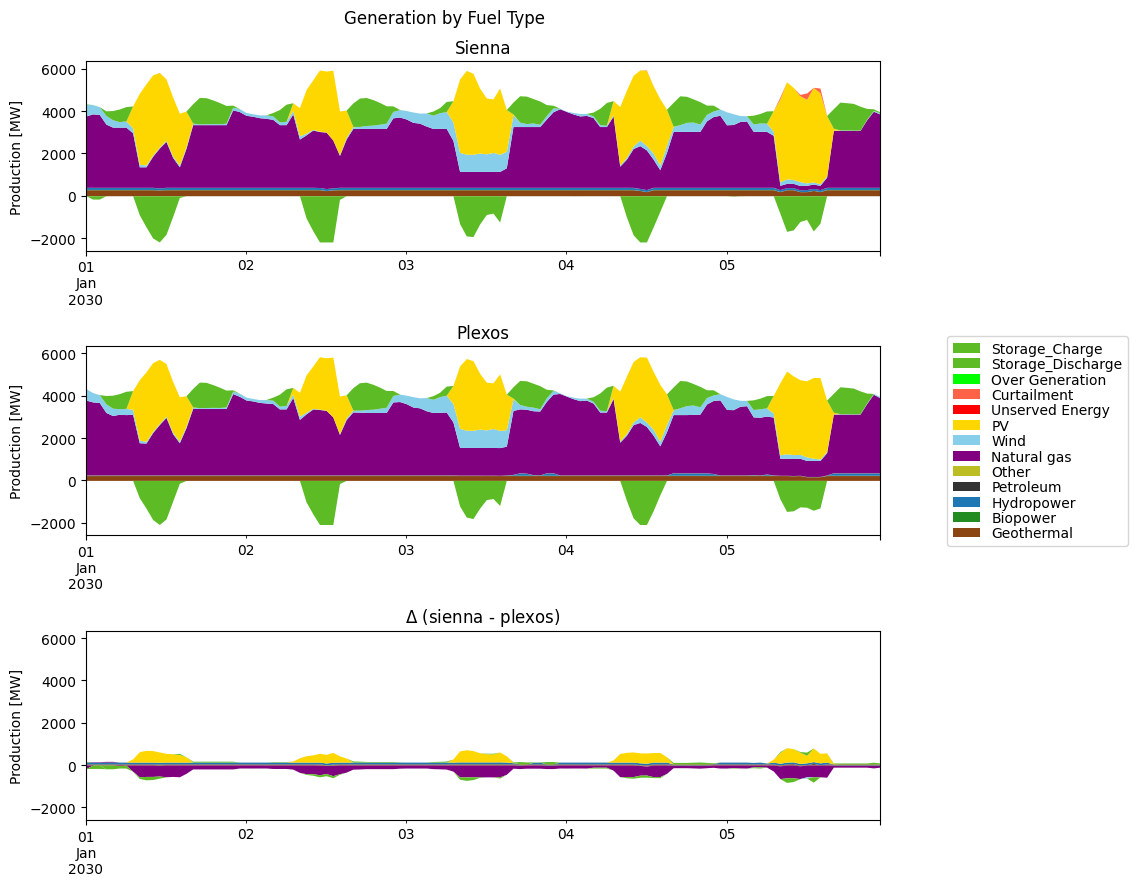

In [276]:
title='Generation by Fuel Type'; save_path='validation/generation_by_fuel.png'; colors=colors_fuel

kwargs = dict(color=colors, ylabel="Production [MW]", xlabel="", linewidth=0)

fig, axes = plt.subplots(3, 1, figsize=(9, 9))

# sienna_resampled = sienna.resample("1D").mean()
sienna.plot.area(
    ax=axes[0],
    **kwargs,
    legend=False,
    title="Sienna",
)
order = sienna.columns

# plexos_resampled = plexos.resample("1D").mean()[order]
plexos.plot.area(
    ax=axes[1],
    **kwargs,
    legend=False,
    title="Plexos",
)

diff = (sienna - plexos).fillna(0)#.resample("1D").mean()
diff.clip(lower=0).plot.area(
    ax=axes[2],
    title=r"$\Delta$ (sienna - plexos)",
    legend=False,
    **kwargs,
)
diff.clip(upper=0).plot.area(ax=axes[2], **kwargs, legend=False)

lower_lim = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
upper_lim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
axes[0].set_ylim(bottom=lower_lim, top=upper_lim)
axes[1].set_ylim(bottom=lower_lim, top=upper_lim)

# Set the limits for the difference subplot
diff_lim_upper = diff.clip(lower=0).sum(axis=1).max()
diff_lim_lower = diff.clip(upper=0).sum(axis=1).min()
axes[2].set_ylim(
    bottom=min(lower_lim, diff_lim_lower),
    top=max(upper_lim, diff_lim_upper),
)

h, l = axes[0].get_legend_handles_labels()
fig.legend(
    h[::-1],
    l[::-1],
    loc="center left",               # Aligns the legend to the left of the bounding box
    bbox_to_anchor=(1.05, 0.5),      # 1.05 moves it slightly outside the plot, 0.5 centers it vertically
    ncol=1,
    frameon=True,
    labelspacing=0.1,
)

plt.suptitle(title)
fig.tight_layout()
fig.savefig(save_path, dpi=300)

In [261]:
df_plexos_match = df_plexos_generation.loc[df_sienna_gen.index, df_sienna_gen.columns]


In [262]:
df_plexos_match

,Clark 17,Clark Mt. 3,Clark 14,LV Gen 3_A,Clark 13,Sun Peak 3,Clark 18,"Clark 5, 6, 10_A",LV Gen 2_B,LV Gen 2_A,...,Sierra Solar,FRV Spectrum Solar,RV Apex Solar,Arrow Canyon Solar,Silver State Solar,Ft. Churchill Solar,Libra Solar,Boulder Solar III,Gemini Solar,Copper Mountain Solar 5
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,0,0,0,0,0,0,0,0,0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 01:00:00,0,0,0,0,0,0,0,0,0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 02:00:00,0,0,0,0,0,0,0,0,0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 03:00:00,0,0,0,0,0,0,0,0,0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 04:00:00,0,0,0,0,0,0,0,0,0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-01-05 19:00:00,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-05 20:00:00,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-05 21:00:00,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
df_plexos_match - df_sienna_gen

,Clark 17,Clark Mt. 3,Clark 14,LV Gen 3_A,Clark 13,Sun Peak 3,Clark 18,"Clark 5, 6, 10_A",LV Gen 2_B,LV Gen 2_A,...,Sierra Solar,FRV Spectrum Solar,RV Apex Solar,Arrow Canyon Solar,Silver State Solar,Ft. Churchill Solar,Libra Solar,Boulder Solar III,Gemini Solar,Copper Mountain Solar 5
DateTime,,,,,,,,,,,,,,,,,,,,,
2030-01-01 00:00:00,0.0,-72.999999,0.0,0.0,0.0,0.0,-39.860097,0.0,0.0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 01:00:00,0.0,-72.999999,0.0,0.0,0.0,0.0,-35.000103,0.0,0.0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 02:00:00,0.0,-72.999999,0.0,0.0,0.0,0.0,-35.000126,0.0,0.0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 03:00:00,0.0,-72.999999,0.0,0.0,0.0,0.0,-39.859993,0.0,0.0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-01 04:00:00,0.0,-72.999999,0.0,0.0,0.0,0.0,-39.859984,0.0,0.0,57.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-01-05 19:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-74.4,-74.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-05 20:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-74.4,-74.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2030-01-05 21:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-74.4,-74.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Sienna Purchases'}, xlabel='DateTime'>

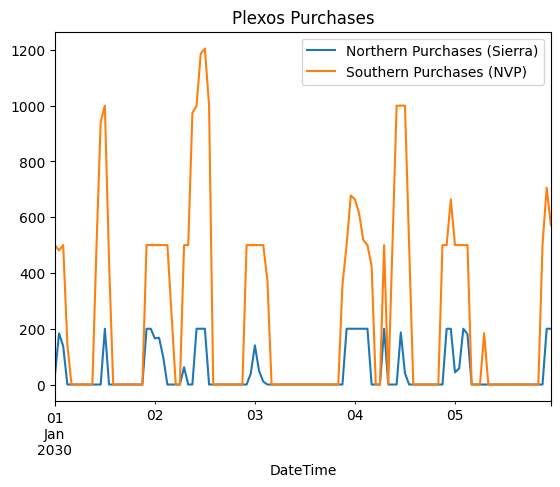

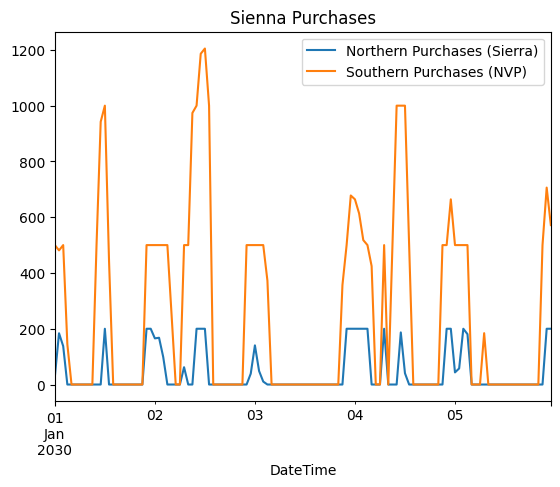

In [264]:
df_plexos_match[['Northern Purchases (Sierra)', 'Southern Purchases (NVP)']].plot(title='Plexos Purchases')
df_sienna_gen[['Northern Purchases (Sierra)', 'Southern Purchases (NVP)']].plot(title='Sienna Purchases')

## Compare Line Flows

In [265]:
# Read Plexos Results
df_plexos_tx = pd.read_excel(plexos_results_path, sheet_name='TX')
df_plexos_tx.drop(columns=[	"Parent Name", "Collection", "Property", "Band", "Units"], inplace=True)
df_plexos_tx.rename(columns={"Datetime": "DateTime"}, inplace=True)
df_plexos_tx.set_index('DateTime', inplace=True)
df_plexos_tx


,Northern Import-Export (Sierra),ON Line (NVP to Sierra),Southern Import-Export (NVP)
DateTime,,,
2030-01-01 00:00:00,27.869,570.611,500.000
2030-01-01 01:00:00,183.896,453.057,480.947
2030-01-01 02:00:00,137.762,530.529,500.000
2030-01-01 03:00:00,0.000,583.761,144.039
2030-01-01 04:00:00,0.000,694.255,0.000
...,...,...,...
2030-01-07 19:00:00,0.000,889.191,0.000
2030-01-07 20:00:00,200.000,777.787,500.000
2030-01-07 21:00:00,200.000,718.808,801.888


In [266]:
# Read Sienna Resuts
df_sienna_tx = pd.read_csv(sienna_results_folder / 'tx_flow.csv')
df_sienna_tx['DateTime'] = pd.to_datetime(df_sienna_tx['DateTime'])
df_sienna_tx.set_index('DateTime', inplace=True)
df_sienna_tx

,Northern Import-Export (Sierra),Southern Import-Export (NVP),ON Line (NVP to Sierra)
DateTime,,,
2030-01-01 00:00:00,27.87,500.00,899.899456
2030-01-01 01:00:00,183.90,480.95,879.857221
2030-01-01 02:00:00,137.76,500.00,960.762911
2030-01-01 03:00:00,0.00,144.04,961.084565
2030-01-01 04:00:00,0.00,0.00,947.969189
...,...,...,...
2030-01-05 19:00:00,0.00,0.00,1042.743231
2030-01-05 20:00:00,0.00,0.00,849.838271
2030-01-05 21:00:00,0.00,500.00,963.663731


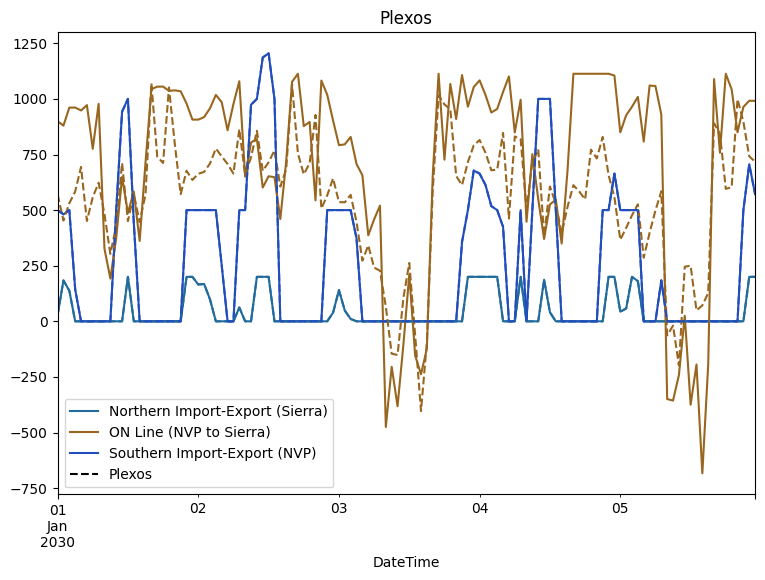

In [267]:
import random
df_plexos_tx = df_plexos_tx.loc[df_sienna_tx.index]

colors_tx = {column: "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for column in df_sienna_tx.columns}

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
df_sienna_tx.plot(ax=ax, title='Sienna', legend=False, color=colors_tx)
df_plexos_tx.plot(ax=ax, title='Plexos', legend=False, linestyle='--', color=colors_tx)

# Set the same color for lines with the same name
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]

# Add handles for dashed lines
dashed_handles = [plt.Line2D([], [], linestyle='--', color='black', label='Plexos')]
dashed_labels = ['Plexos']

# Combine all handles and labels
all_handles = unique_handles + dashed_handles
all_labels = unique_labels + dashed_labels

ax.legend(all_handles, all_labels)

In [268]:
df_sienna_pc = pd.read_csv(sienna_results_folder / 'production_costs.csv')

df_sienna_pc['DateTime'] = pd.to_datetime(df_sienna_pc['DateTime'])
df_sienna_pc.set_index('DateTime', inplace=True)

df_sienna_pc.sum(axis=1).resample("1D").sum()

DateTime
2030-01-01    1.553923e+06
2030-01-02    1.556802e+06
2030-01-03    1.356688e+06
2030-01-04    1.378145e+06
2030-01-05    1.149099e+06
Freq: D, dtype: float64

In [269]:
def harry_plexos(production):
    constant = 4131.864122174
    set_point_coeff = 4.224868900963997

    tranch_rates = [- 72.18474708879999 , - 62.82746505604, - 54.1187075206, - 46.05847448248, - 38.64676594168,  - 31.8835819350, - 25.7689223889 , - 20.30278734006, - 15.4851767885]

    tranch_coeffs = [0.0693069306930693, 0.0796292395196966, 0.09244314013206, 0.1086206896551725, 0.129452054794,  0.156911581569115,  0.194144838212635, 0.2464146023468058, 0.27]

    tranch_setpoints = [coeff * production for coeff in tranch_coeffs]

    tranch_costs = 0
    for i in range(len(tranch_rates)):
        tranch_costs += tranch_rates[i] * tranch_setpoints[i]

    return (
        constant 
        + set_point_coeff * production
        + tranch_costs
    )


# x = np.linspace(0, 40, 20)
# y = [harry_plexos(i) for i in x]
# plt.plot(x, y)
# # plt.legend()
# y

# Outstanding Issues

## R2X


## Sienna
- MarketBid Cost
- Max Energy Monthly for Market Purchases ThermalStandard Objects, and for The Hydro Resources

Max Energy Month:
- imports as transmission interface with a schedule. ... max energy month gets captured on the interfaces.

Services:
- turn off A/S for storage , and once completely
- export the plexos allocation of reserves to units

Plotting:
- LMP spread